# Discrete Population Compartmental Model

Treats the population as discrete rather than continuous.

In [1]:
# Import those libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from numpy import genfromtxt
import matplotlib.image as mpimg
import pandas as pd
import scipy
import time
from operator import add
from scipy.stats import binom
from numpy import random
from joblib import Parallel, delayed
import collections
import csv

In [2]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

In [3]:
waloc = pd.read_csv('/Users/Yuval/Desktop/Thesis/all-wa-pos.csv')#use this for all 297 towns
waloc = waloc.loc[waloc['Population'] >0]
# When doing big towns
waloc = waloc[:58]
# When ignoring sattelite towns
waloc = waloc.loc[(waloc['City / Town'] != 'Yanchep') & (waloc['City / Town'] != 'Bullsbrook') &
                  (waloc['City / Town'] != 'Mundijong') & (waloc['City / Town'] != 'Serpentine') &
                 (waloc['City / Town'] != 'Two Rocks') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

In [5]:
# Create a network from a weekly dataset
my_data = genfromtxt('/Volumes/HardDrive/New_Workflow/symm_stoc_53/Town_Flow_20200322_20200328.csv',delimiter = ',')
A = nx.from_numpy_matrix(my_data)
A = nx.DiGraph(A)

# Use this network to label all the nodes, matching their index to the town name
towns = list(waloc['City / Town'])
labeldict = {}
for node in list(A.nodes()):
    labeldict[node] = towns[node]

In [6]:
# Read in all weekly adjacnecy matrices, assigning each entry to a dictionary.
st = os.listdir("/Volumes/HardDrive/New_Workflow/symm_stoc_53")

stoch = []
for i in st:
    if '._' not in i:
        stoch.append(i)
        
d = {}
for i in range(len(stoch)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/New_Workflow/symm_stoc_53/"+stoch[i], header = None, sep =',')

In [7]:
# Create a df which is the average of all the flows, set it as key 100 in the dictionary 
# (so it's only referred to by choice)
df = d['0'].copy()
for i in range(1,len(stoch)):
    df += d[str(i)]
df = df/len(stoch)
d['100'] = df

In [8]:
def sveir(params,x,popn,changes,effic):
    xdot = list(np.zeros(7))
    eff1, eff2, eff3 = effic[0], effic[1], effic[2]
    xdot[0] = 1/84*x[6]- params[0]*x[0]*x[5]/popn - changes[0] # Susceptible
    xdot[1] = -eff1*params[0]*x[1]*x[5]/popn +changes[0] - changes[1] #One Dose
    xdot[2] = -eff2*params[0]*x[2]*x[5]/popn + changes[1] - changes[2] # Two doses
    xdot[3] = -eff3*params[0]*x[3]*x[5]/popn + changes[2]
    xdot[4] = params[0]*x[0]*x[5]/popn + eff1*params[0]*x[1]*x[5]/popn + eff2*params[0]*x[2]*x[5]/popn + eff3*params[0]*x[3]*x[5]/popn - params[1]*x[4] #Exposed
    xdot[5] = params[1]*x[4] - params[2]*x[5] # Infected
    xdot[6] = params[2]*x[5] - 1/84*x[6] # Removed
    
    infected_daily = params[1]*x[4]
    
    return xdot, infected_daily

In [51]:
def bernoulli(flow,x,pop, town):
    
    t = town
    
    p1 = x[0]/pop 
    p2 = x[1]/pop
    p3 = x[2]/pop
    p4 = x[3]/pop
    p5 = x[4]/pop
    p6 = x[5]/pop
    p7 = x[6]/pop
    
    #truth = True
    
#     vector = []
#     for i in range(flow):
#         r1 = random.rand()
#         if r1 <= p1:
#             vector.append(0)
#         elif (r1>p1) & (r1 <= (p1+p2)):
#             vector.append(1)
#         elif (r1 > p1+p2) & (r1 <= p1+p2+p3):
#             vector.append(2)
#         elif (r1 > p1+p2+p3) & (r1 <= p1+p2+p3+p4):
#             vector.append(3)
#         elif (r1 > p1+p2+p3+p4) & (r1 <= p1+p2+p3+p4+p5):
#             vector.append(4)
#         elif (r1 > p1+p2+p3+p4+p5) & (r1 <= p1+p2+p3+p4+p5+p6):
#             vector.append(5)
#         elif (r1 > p1+p2+p3+p4+p5+p6):
#             vector.append(6)
            
    vector = []
    while len(vector) <flow:
        r1 = random.rand()
        if (r1 <= p1) & (vector.count(0) < x[0]):
            vector.append(0)
        elif (r1>p1) & (r1 <= (p1+p2)) & (vector.count(1) < x[1]):
            vector.append(1)
        elif (r1 > p1+p2) & (r1 <= p1+p2+p3)& (vector.count(2) < x[2]):
            vector.append(2)
        elif (r1 > p1+p2+p3) & (r1 <= p1+p2+p3+p4) & (vector.count(3) < x[3]):
            vector.append(3)
        elif (r1 > p1+p2+p3+p4) & (r1 <= p1+p2+p3+p4+p5) & (vector.count(4) < x[4]):
            vector.append(4)
        elif (r1 > p1+p2+p3+p4+p5) & (r1 <= p1+p2+p3+p4+p5+p6) & (vector.count(5) < x[5]):
            vector.append(5)
        elif (r1 > p1+p2+p3+p4+p5+p6) & (vector.count(6) < x[6]):
            vector.append(6)

    occ = dict(collections.Counter(vector))
    for i in range(7):
        occ[i] = occ.get(i,0)
        
#     for i in range(7):
#         if occ[i] > x[i]:
#             truth = False

    return occ

In [52]:
def dynamics(x_init, num, steps, params, popn, changes):
    
    x = x_init
    y = []
    changes = [0,0,0]
    
    town_infs = []
    for i in range(num):
        
        xy = []
        infected_daily = []
        for t in range(steps):
            if t == 0:
                xdot, infs = sveir(params, x[i],popn[i], changes, effic)
                xdot = [n/steps for n in xdot]
                xy.append([sum(n) for n in zip(*[x[i],xdot])])
                infected_daily.append(infs)
            else:
                xdot, infs = sveir(params, xy[-1],popn[i], changes, effic)
                xdot = [n/steps for n in xdot]
                xy.append([sum(n) for n in zip(*[xy[-1],xdot])])
                infected_daily.append(infs)
            #print(xy)
            
        town_infs.append(sum(infected_daily)/steps)
        xxy = []
        for j in xy[-1]:
            try:
                xxy.append(int(j))
            except:
                print(i,j)
        y.append(xxy)
        #y.append([int(j) for j in xy[-1]])
        #print(i,j)
    
    return y, town_infs

In [53]:
def movement(x_init, day, num_towns,popn):
        
    week = int(day//7)+70

    flow = d[str(week)].copy()*C/7
    
    move = []
    for i in range(num_towns):
        temp_mo = []
        for j in range(num_towns):
            pop = popn[i]
            if int(flow[i][j]) == 0:
                mo = [0,0,0,0,0,0,0]
            else:
#                 truth = False
#                 while truth == False:
                mo= bernoulli(int(flow[i][j]),x_init[i], pop, town)
            temp_mo.append(mo)
        
        move.append(temp_mo)
        
    out = []   
    inc = []
    for i in range(num_towns):
        temp_out = []
        temp_inc = []
        for k in range(7):
            mini_out = []
            mini_inc = []
            for j in range(num_towns):
                mini_out.append(move[i][j][k])
                mini_inc.append(move[j][i][k])
            temp_out.append(sum(mini_out))
            temp_inc.append(sum(mini_inc))
        out.append(temp_out)
        inc.append(temp_inc)            

    return inc, out

In [54]:
# Number of towns we'll be investigating in this run (max = 53 for bigs only, 58 with sattelite towns,
# 297 for all towns)
num = 49
#Go with similar proportions as Adeliade for now
infect = 4.75*10**(-6)
x_init = [0.02,0.02,0.85,0.11-(5*infect),4*infect,infect,0]
#x_init = [1770000-(1380635+32+8),1380635-1264948,1264948-38710,38710,32,8,0]
#for i in range(len(x_init)):
#    x_init[i] = x_init[i]/1770000

# Go with 0 infections elsewhere
y_init = [0.02,0.02,0.85,0.11,0,0,0]
init = [x_init]
for i in range(num-1):
    init.append(y_init)

## Multiply it by population in each town.
popn = list(waloc['Population'])
#popn[0] = 1770000

town_init = []
for i in range(num):
    item = init[i]
    new_item = []
    for j in range(len(item)):
        new_item.append(item[j] * popn [i])
    town_init.append(new_item)  
    
    
days = 115
steps = 20


#a1, a2,a3, L, D =4.26855088, 4.50297884, 6.        , 0.5       , 0.80237211
a1, a2,a3, L, D =0.6087795 , 0.18593849, 0.55574211, 2.        , 5.
effic = [1-0.293, 1-0.128, 1-0.58]

C= 9*10**9
changes = [0,0,0]

In [55]:
params = [a1, 1/L, 1/D]

model = [town_init]

x_init = town_init

day_infs = [0]

for day in range(days):
    print(day)

    if day < 40:
        params[0] = a1
    elif (day>= 40) and (day < 80):
        params[0] = a2
    elif day >=80:
        params[0] = a3
        
    dyn, town_infs = dynamics(model[-1], num, steps, params, popn, changes)
    
    day_infs.append(sum(town_infs) + day_infs[-1])
    
    inc, out = movement(model[-1], day, num, popn)
    
    dynmov = []
    for i in range(num):
         dynmov.append([dyn[i][d] + inc[i][d] - out[i][d] for d in range(7)])

    model.append(dynmov)
    
#     if day%7 == 0:
#         inc, out = movement(model[-1], day, num, popn)

#         dynmov = []
#         for i in range(num):
#              dynmov.append([dyn[i][d] + inc[i][d] - out[i][d] for d in range(7)])

#         model.append(dynmov)
#     else:
#         model.append(dyn)

0


KeyboardInterrupt: 

In [35]:
# Compare total infections to WA outbreak
wa_totals = list(pd.read_csv('/Users/Yuval/Desktop/Thesis/wa_health.csv').iloc[0])[1:]
wa_totals = [i - 1134 for i in wa_totals]
wa_infs = [0]
for i in range(1,len(wa_totals)):
    wa_infs.append(wa_totals[i]-wa_totals[i-1])

Text(0.5, 0, 'Days from outbreak')

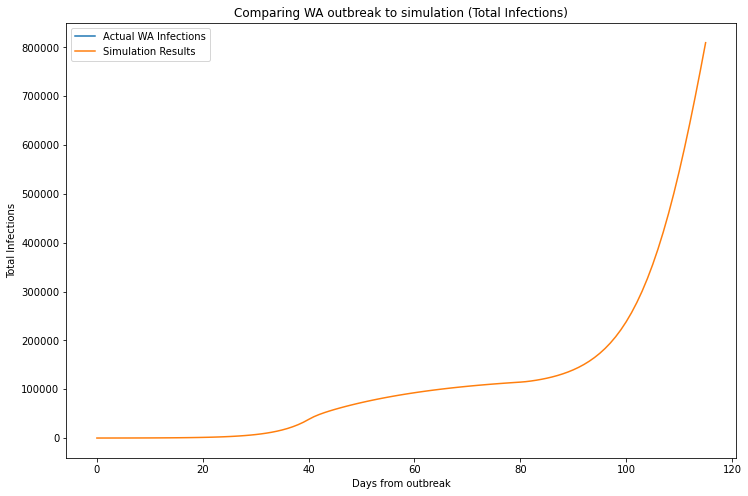

In [36]:
plt.figure(figsize = (12,8))
plt.title('Comparing WA outbreak to simulation (Total Infections)')
plt.plot(wa_totals, label = 'Actual WA Infections')
plt.plot(day_infs, label = 'Simulation Results')
plt.legend()
plt.ylabel('Total Infections')
plt.xlabel('Days from outbreak')

Text(0.5, 0, 'Days from outbreak')

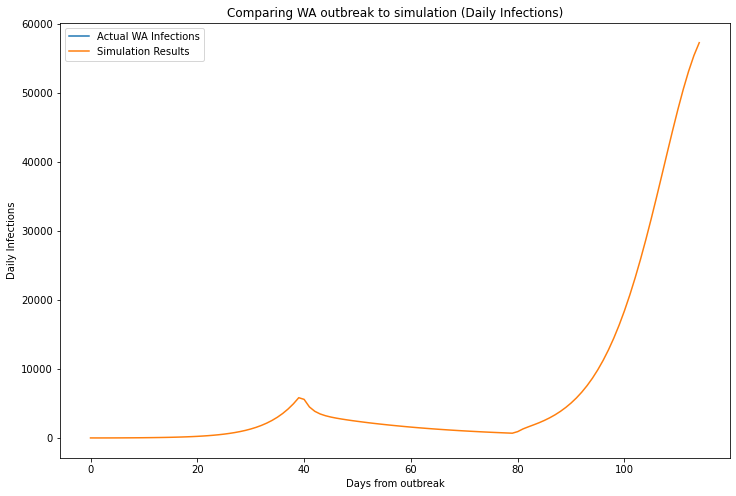

In [37]:
new_infs = [day_infs[i]-day_infs[i-1] for i in range(1,len(day_infs))]
plt.figure(figsize = (12,8))
plt.title('Comparing WA outbreak to simulation (Daily Infections)')
plt.plot(wa_infs, label = 'Actual WA Infections')
plt.plot(new_infs, label = 'Simulation Results')
plt.legend()
plt.ylabel('Daily Infections')
plt.xlabel('Days from outbreak')

In [38]:
# print when infection breaks in to each town
breaks = dict()
for i in range(num):
    for day in range(days):
        if model[day][i][5] > 0:
            breaks[towns[i]] = breaks.get(towns[i], day)

sd = {k: v for k, v in sorted(breaks.items(), key=lambda item: item[1])}
for item in sd:
    print(item, breaks[item])

print('-----Not Affected-----')
for i in range(num):
    if towns[i] not in breaks.keys():
        print(towns[i])

Perth 0
Pinjarra 5
Newman 12
Paraburdoo 12
Wickham 14
Bunbury 16
Tom Price 17
Karratha 18
Kambalda West 18
Port Hedland 21
York 23
Kalgoorlie-Boulder 24
Exmouth 24
Northam 25
Broome 26
Jurien Bay 26
Capel 29
Binningup 30
Donnybrook 31
Geraldton 32
Busselton 32
Merredin 33
Moora 33
Halls Creek 34
Drummond Cove 39
Carnarvon 41
Port Denison-Dongara 41
Collie 42
Harvey 43
Narrogin 46
Dunsborough 59
Bridgetown 63
Kojonup 64
Waroona 75
Cowaramup 88
Margaret River 92
Katanning 96
Manjimup 100
Wagin 107
-----Not Affected-----
Albany
Esperance
Kununurra
Derby
Denmark
Mount Barker
Little Grove
Kalbarri
Boddington-Ranford
Fitzroy Crossing


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


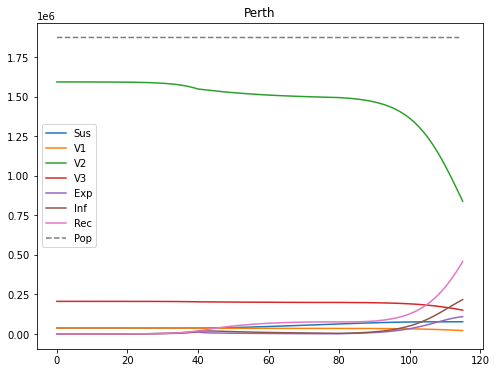

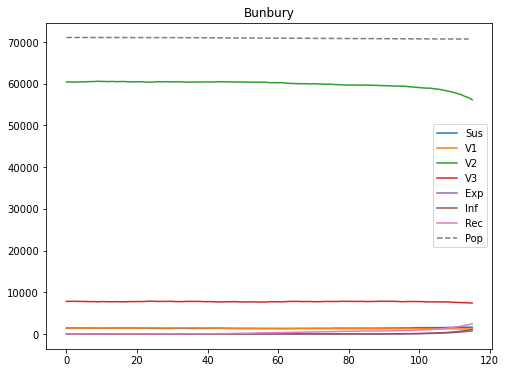

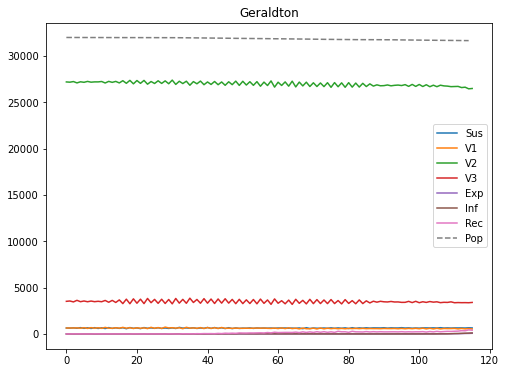

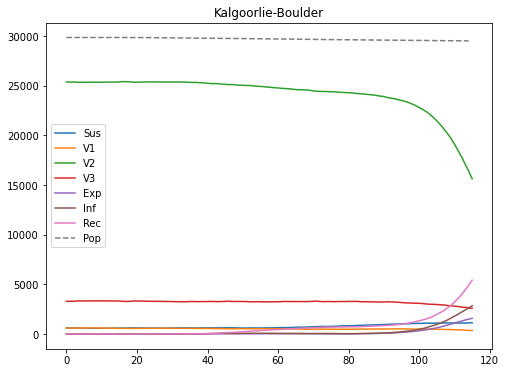

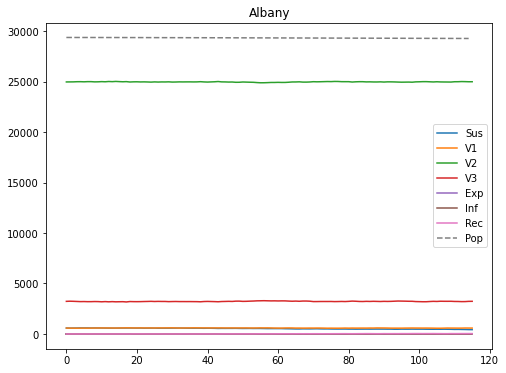

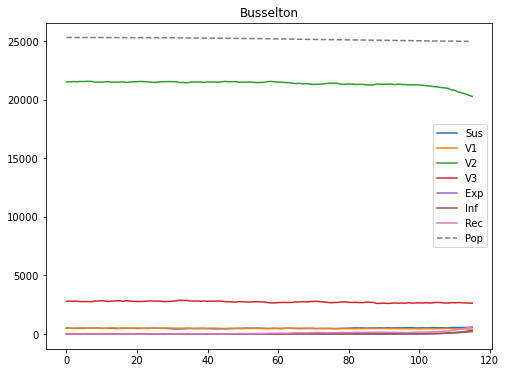

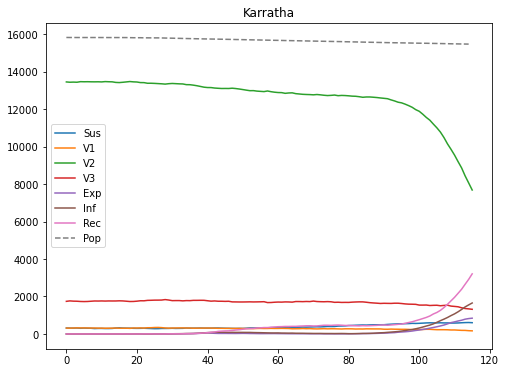

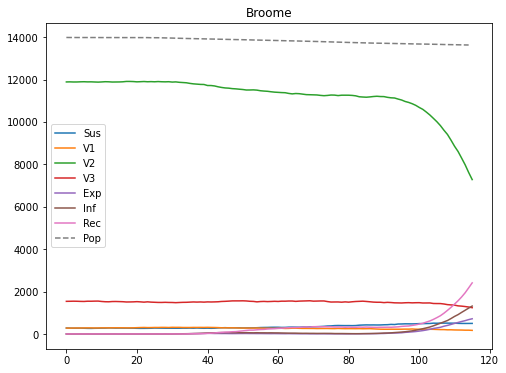

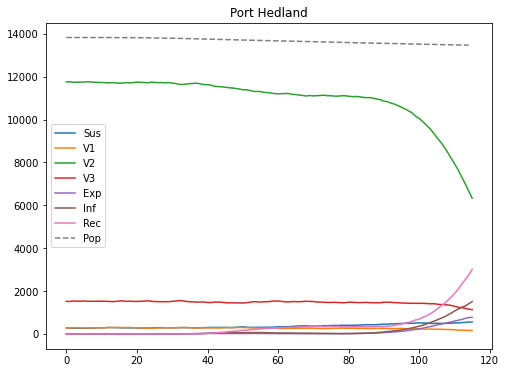

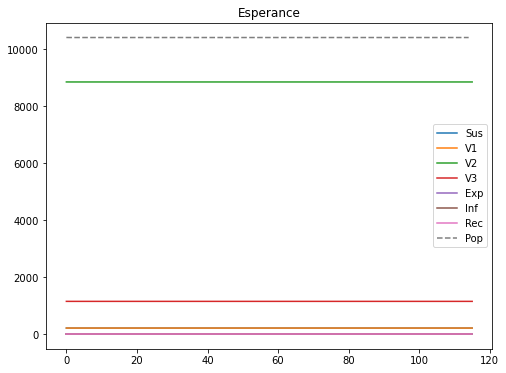

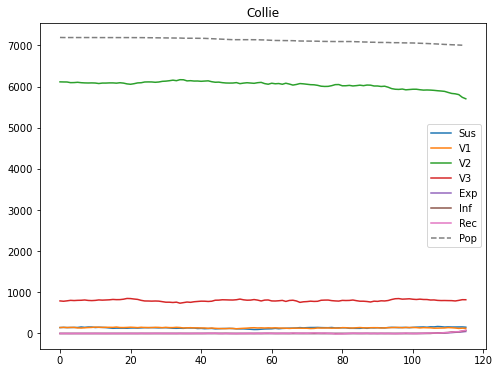

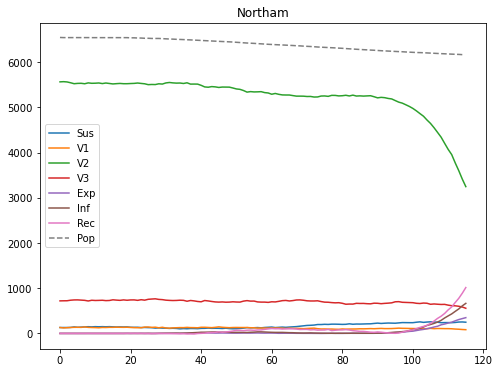

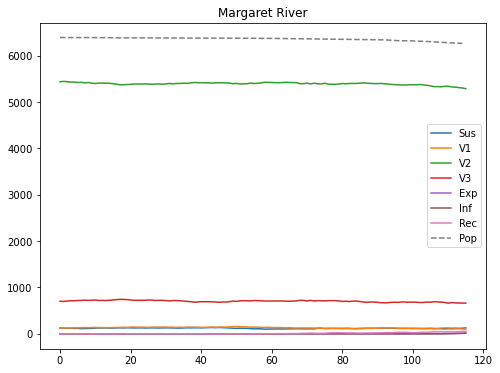

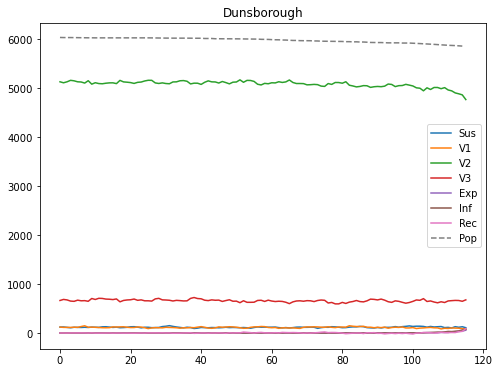

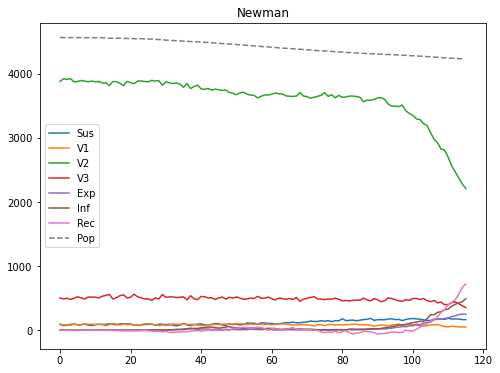

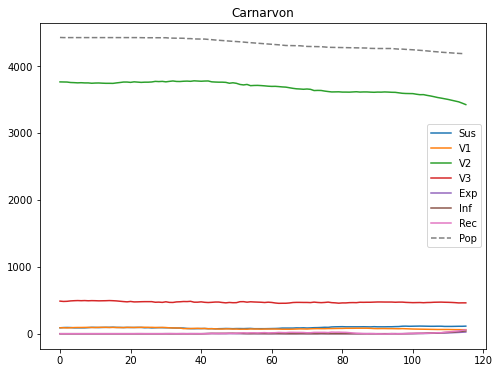

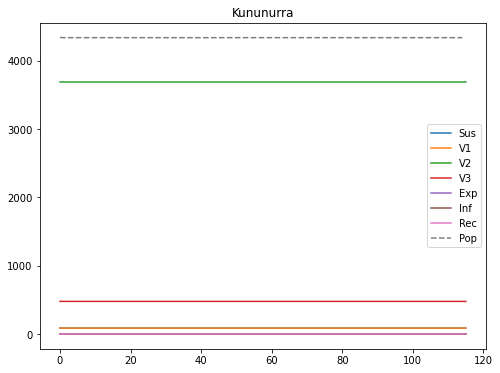

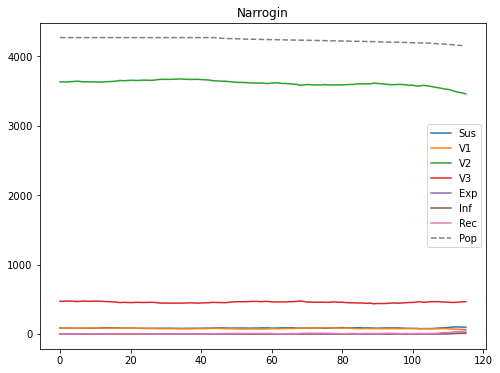

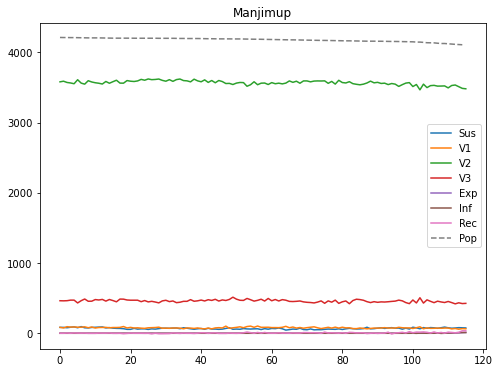

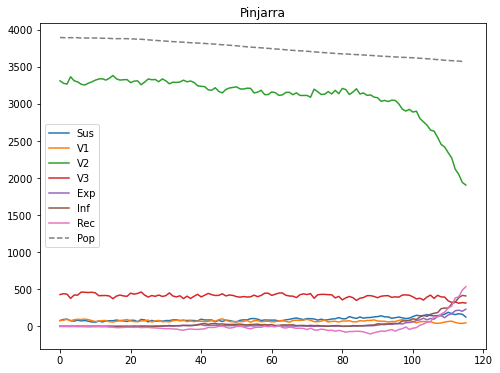

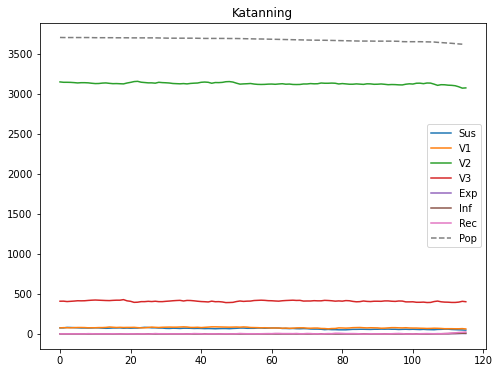

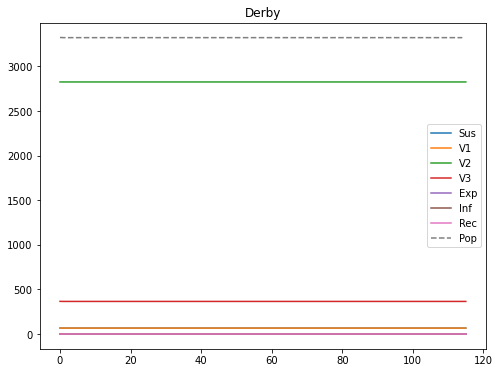

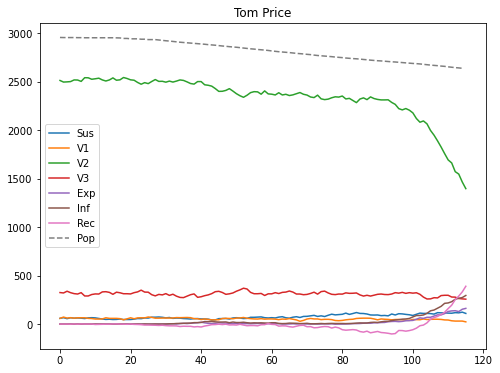

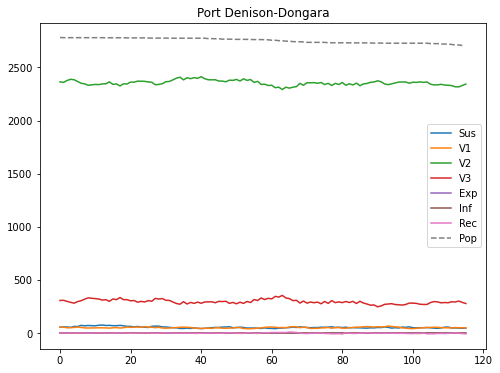

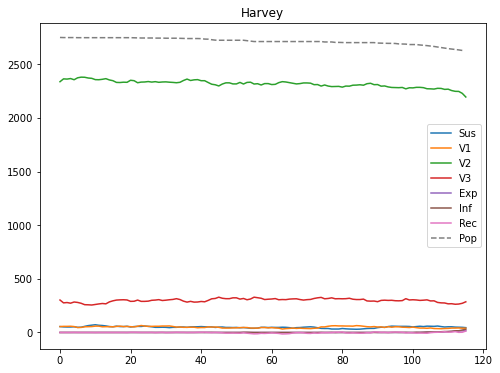

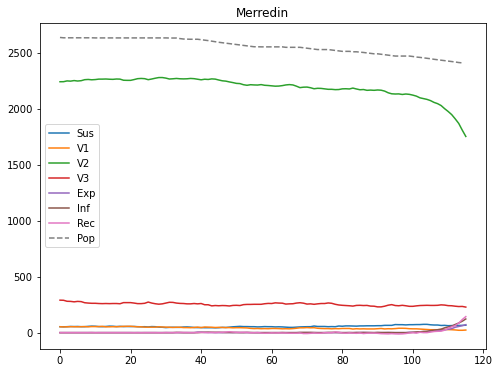

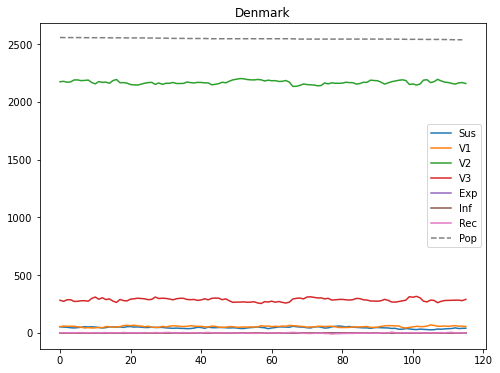

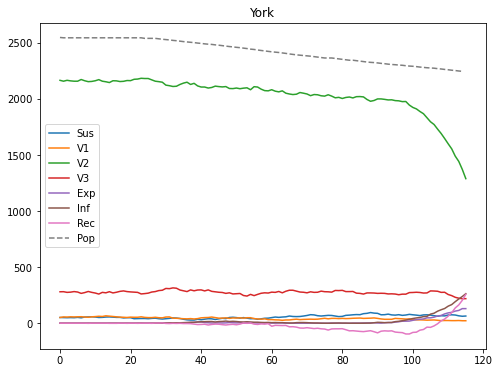

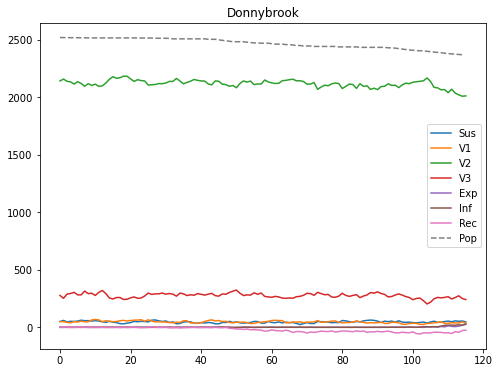

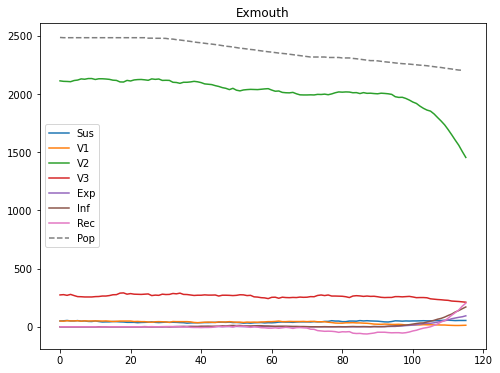

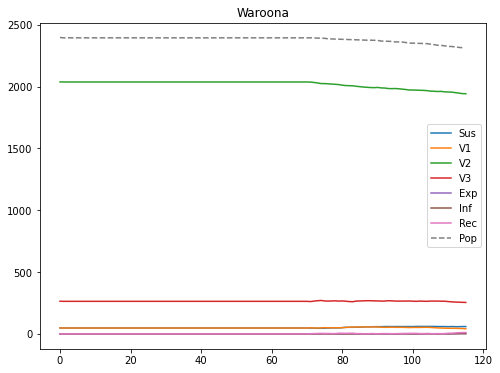

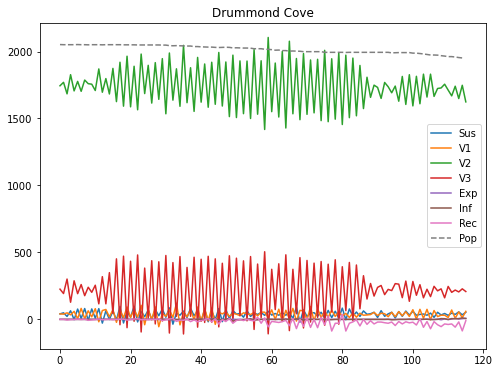

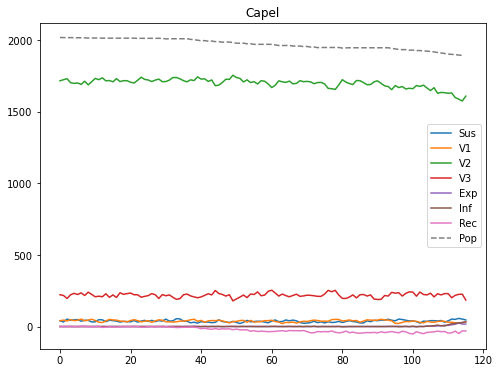

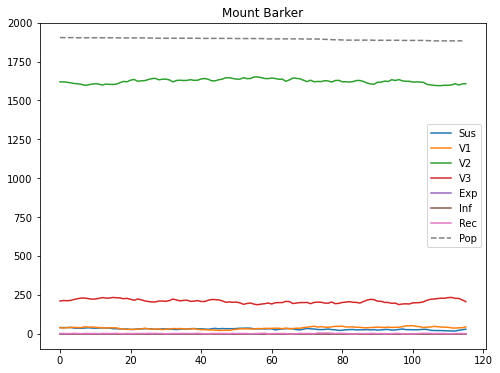

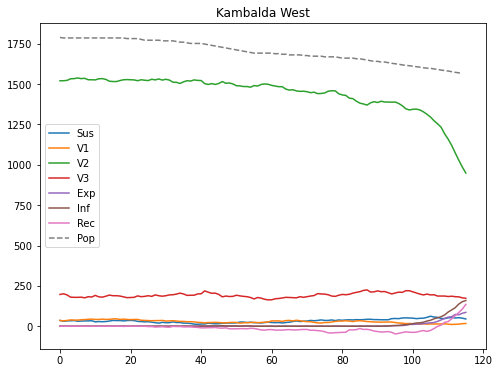

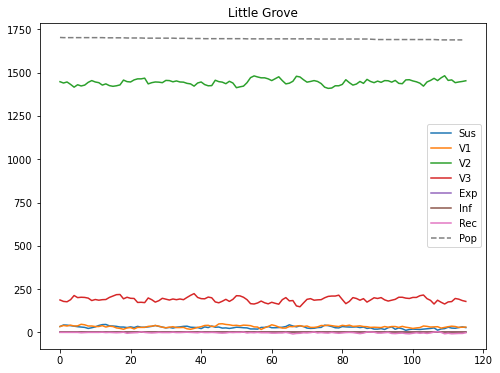

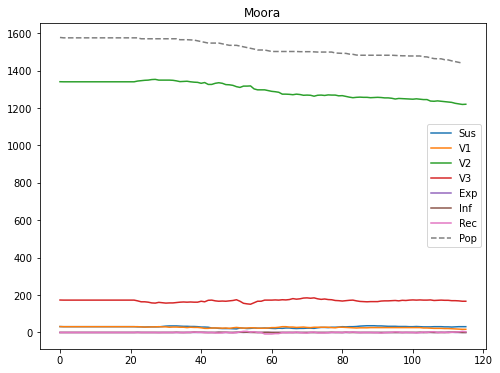

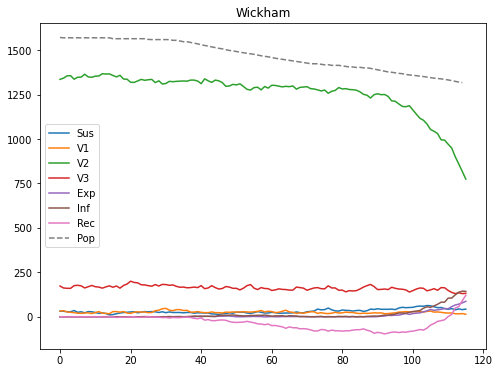

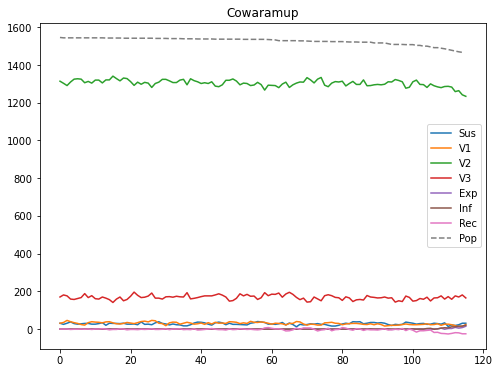

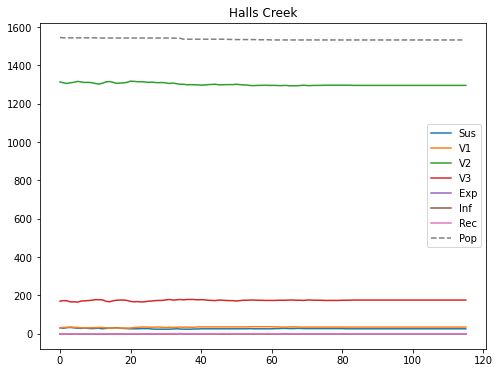

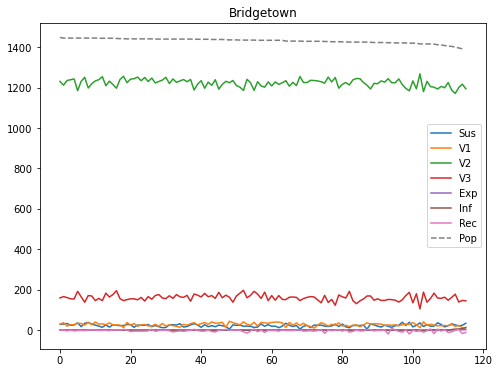

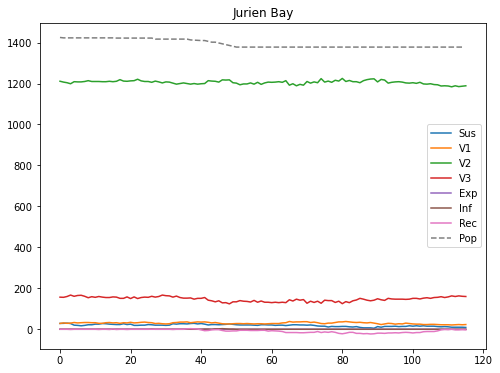

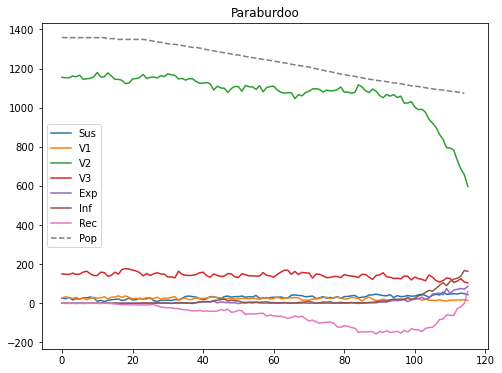

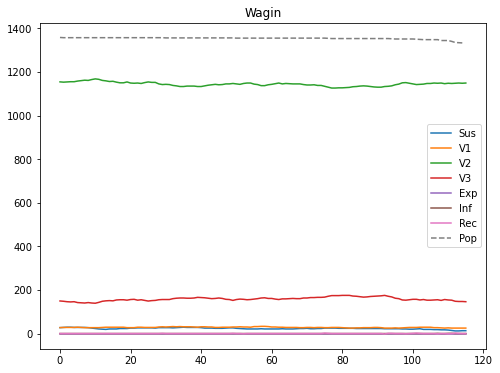

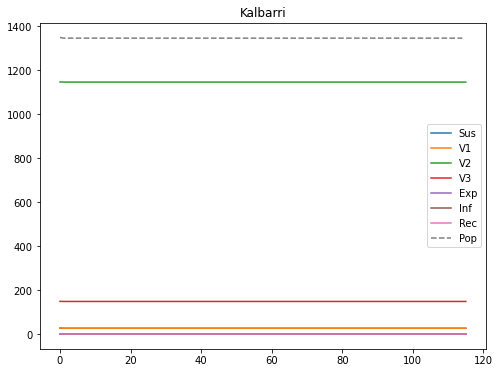

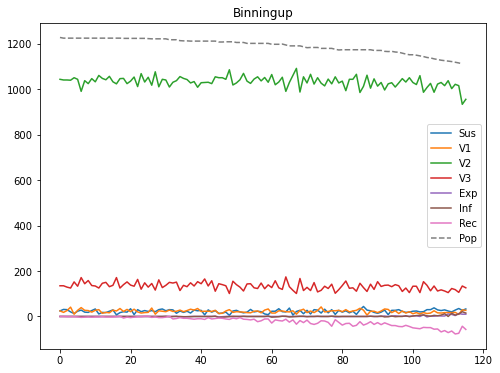

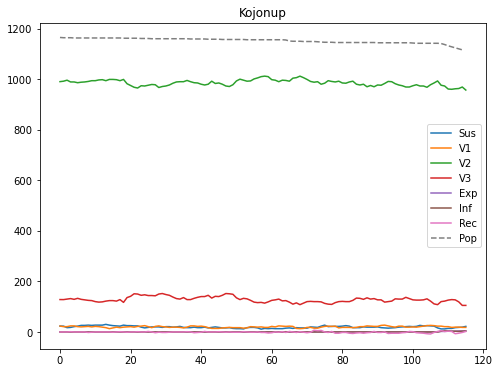

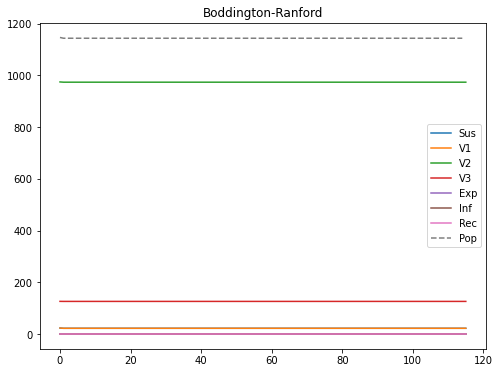

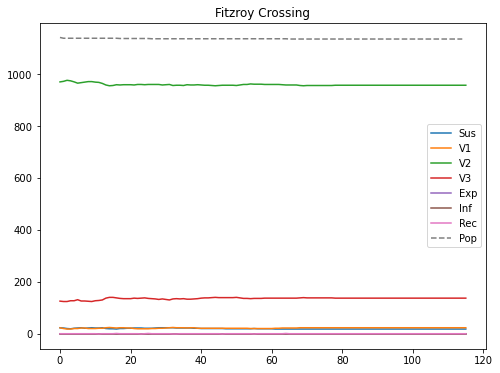

In [39]:
compartments = ['Sus', 'V1', 'V2', 'V3', 'Exp', 'Inf', 'Rec']
for town in range(num):
    plt.figure(figsize = (8,6))
    plt.title(towns[town])
    total_pop = []
    for k in range(8):
        if k < 7:
        #if k == 5:
            llist = []
            for day in range(len(model)):
                llist.append(model[day][town][k])
            plt.plot(llist,label = compartments[k])
        else:
            for day in range(days):
                total_pop.append(sum(model[day][town]))
    plt.plot(total_pop, linestyle = 'dashed', label = 'Pop')
    plt.legend()

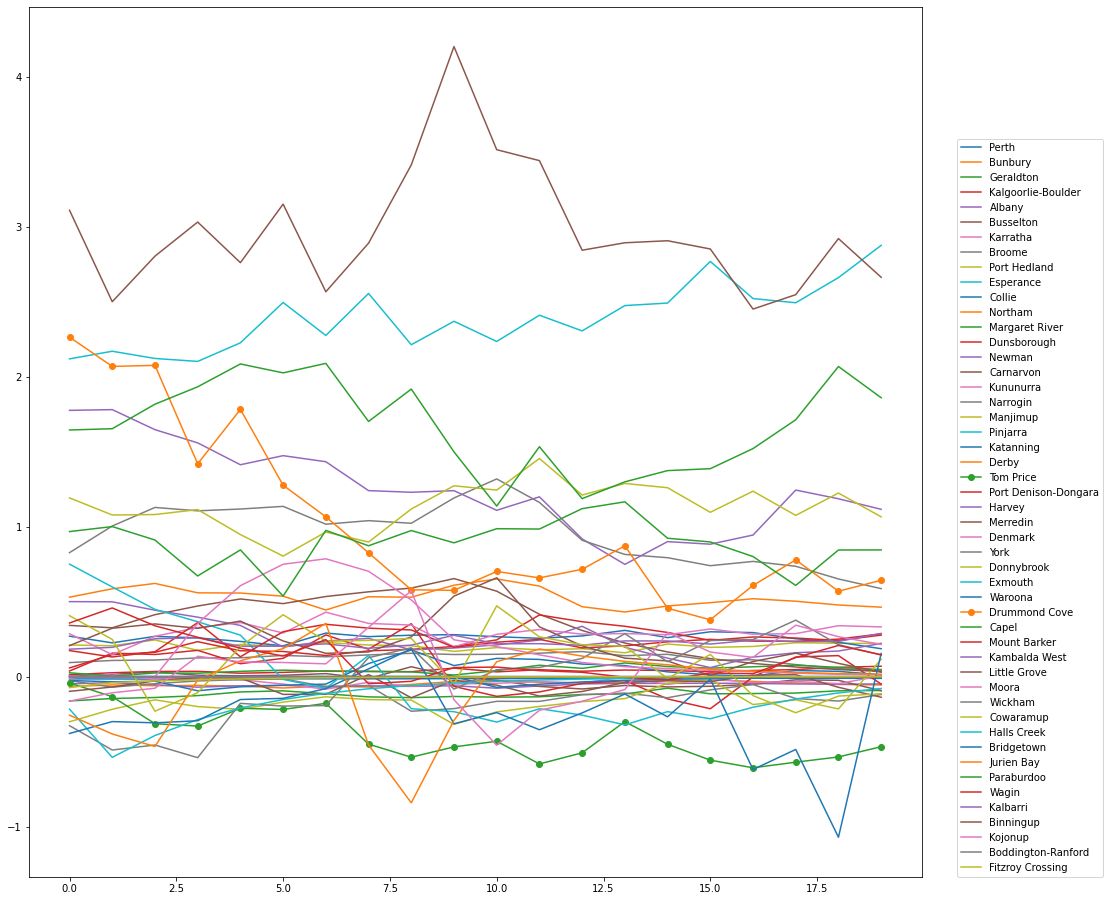

In [82]:
plt.figure(figsize = (16,16))
for i in range(num):
    di = []
    for j in range(20):
        df = d[str(70+j)].copy()*C
    #print(sum(df[50]))
    #print(sum(df.iloc[50]))
        di.append((sum(df[i]) - sum(df.iloc[i]))/popn[i])
    if i == 50 or i==31 or i == 22:
        plt.plot(di, label = towns[i], marker = 'o')
    else:
        plt.plot(di, label = towns[i])
plt.legend(loc=(1.04,0))
    #diff.append(di)
        #print('Diff = ', (sum(df[50]) - sum(df.iloc[50]))/popn[50], i)